# Tutorial1
We show how to train a profitable RL agent on portfolio managemnt with EIIE algorithm on US stock market.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions

In [1]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

2023-03-05 15:20:49,305	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8265
2023-03-05 15:20:51,267	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step 2: Load Configs
Load default config from the file `configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py`

In [2]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /data/sunshuo/qml/TradeMaster/configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/DJI_label_by_DJIindex_3_24_-0.25_0.25.csv'}, 'environment': {'type': 'PortfolioManagementEIIEEnvironment'}, 'agent': {'type': 'PortfolioManagementEIIE', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}, 'trainer': {'type': 'PortfolioManagementEIIETrainer', 'epochs': 2, 'work_dir': 'work_dir/portfolio_management_dj30_eiie_eiie_adam_ms

## Step 3: Build Dataset

In [4]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments

In [5]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [6]:
train_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643501,AAPL,-0.008320,0.002999,-0.010062,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
0,2012-01-04,64.099998,64.129997,63.400002,63.759998,49.393219,AMGN,0.005332,0.005803,-0.005646,-0.225326,-0.005459,0.007794,-0.008521,-0.008222,-0.017393,-0.031253,-0.042012
0,2012-01-04,48.020000,48.380001,47.400002,48.240002,41.672607,AXP,-0.004561,0.002902,-0.017413,-0.136140,-0.003100,0.004561,-0.004885,-0.017185,-0.029824,-0.045096,-0.052918
0,2012-01-04,74.099998,74.599998,73.589996,74.330002,60.821106,BA,-0.003094,0.003632,-0.009956,-0.181742,0.001482,0.002922,-0.007421,-0.004776,-0.002812,-0.013054,-0.001687
0,2012-01-04,93.410004,95.510002,93.410004,94.849998,70.945084,CAT,-0.015182,0.006958,-0.015182,-0.252029,0.009257,0.010322,-0.004803,-0.010627,-0.001714,-0.005438,0.006133


## Step 5: Build Net 
Update information on the state and action dimension. Crreate networks and optimizer for EIIE.

In [7]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

## Step 6: Build Loss Function

In [8]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [9]:
transition = build_transition(cfg)


## Step 8: Build Agent

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [11]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/portfolio_management_dj30_eiie_eiie_adam_mse


## Step 10: RL Agent Training
Train the EIIE agent based on the config and save results in workdir

In [12]:
trainer.train_and_valid()

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.462766%  |   1.141238  | 0.756975%  |  15.019211%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  9.596335%   |   0.450412  | 2.141257%  |  31.037195%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.460853%  |   1.141237  | 0.756970%  |  15.019067%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

## Step 11: RL Agent Testing

In [12]:
trainer.test();

Resume checkpoint /data/sunshuo/qml/TradeMaster/work_dir/portfolio_management_dj30_eiie_eiie_adam_mse/checkpoints/best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  14.641799%  |   1.304315  | 0.718882%  |  6.743468%   |
+--------------+-------------+------------+--------------+


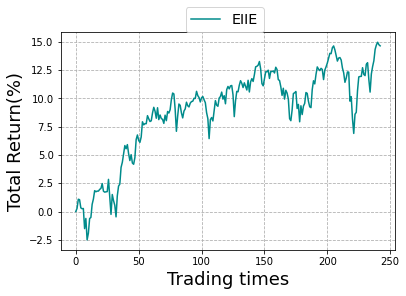

In [16]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")